# Forecasting Hourly Energy Use with Prophet

We will be using hourly energy consumption data from PJM East.

In [1]:
import numpy as np
from fbprophet import Prophet
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

In [2]:
pjme = pd.read_csv('data/PJME_hourly.csv',
                   index_col=[0], parse_dates=[0]) # We set the index column and know it has dates

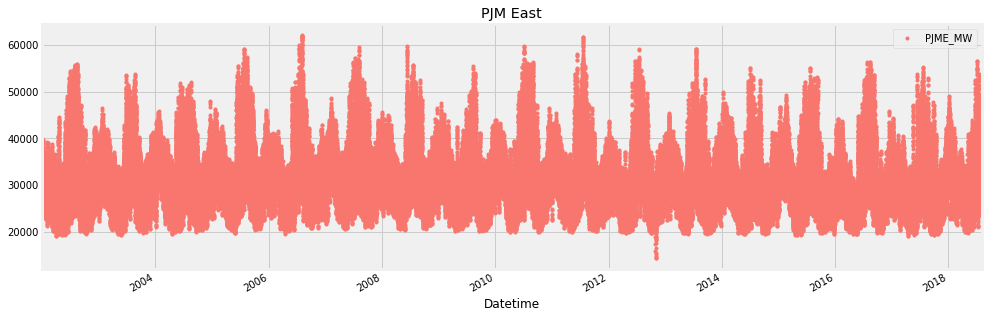

In [3]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')
plt.show()

We will create some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

In [4]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

In [5]:
# See our features and target
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


### Plotting features to see trends

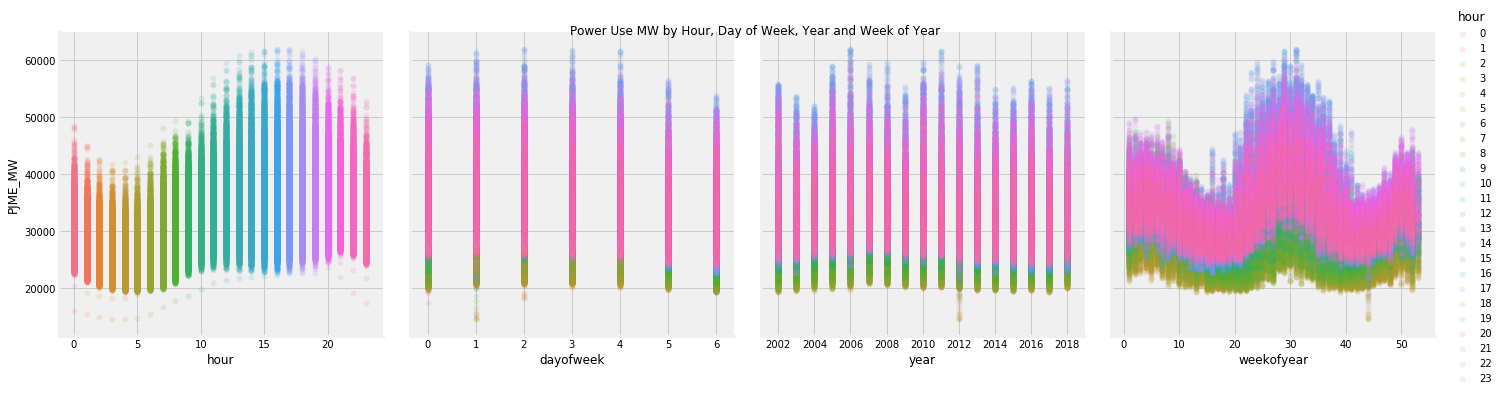

In [6]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

We can see that power demand has strong daily and seasonal properties. Day of week also seems to show differences in peaks.

### Data Validation

In [7]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

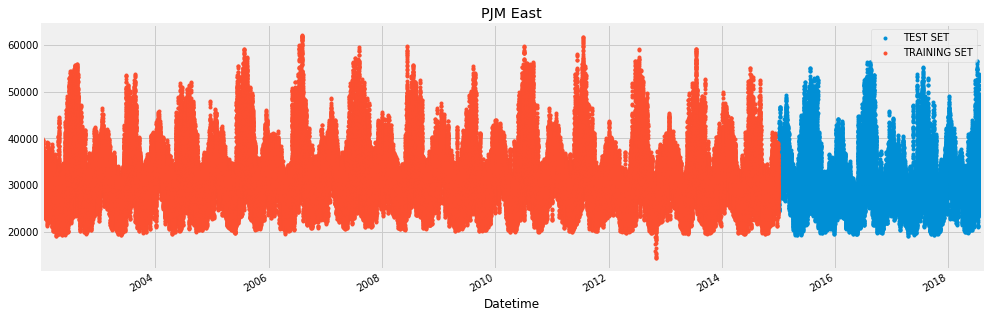

In [8]:
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

We will rename our dataframe columns before feeding it into the model.

In [9]:
# Format data for prophet model using ds and y
pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'}).head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [10]:
# Setup and train model and fit
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW':'y'}))

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [11]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [12]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31213.115893,23892.471981,32765.952369,31213.115893,31213.115893,-2849.698873,-2849.698873,-2849.698873,-4430.365326,...,1281.404077,1281.404077,1281.404077,299.262376,299.262376,299.262376,0.0,0.0,0.0,28363.417019
1,2015-01-01 02:00:00,31213.079053,22436.981819,31577.074257,31213.079053,31213.079053,-4354.078881,-4354.078881,-4354.078881,-5927.276895,...,1272.645500,1272.645500,1272.645500,300.552514,300.552514,300.552514,0.0,0.0,0.0,26859.000172
2,2015-01-01 03:00:00,31213.042214,21497.109554,30298.833699,31213.042214,31213.042214,-5225.790889,-5225.790889,-5225.790889,-6790.356185,...,1262.681137,1262.681137,1262.681137,301.884159,301.884159,301.884159,0.0,0.0,0.0,25987.251325
3,2015-01-01 04:00:00,31213.005375,21503.731759,30295.029146,31213.005375,31213.005375,-5367.366177,-5367.366177,-5367.366177,-6922.258101,...,1251.634587,1251.634587,1251.634587,303.257337,303.257337,303.257337,0.0,0.0,0.0,25845.639198
4,2015-01-01 05:00:00,31212.968536,21803.459078,30901.017118,31212.968536,31212.968536,-4693.049999,-4693.049999,-4693.049999,-6237.363729,...,1239.641657,1239.641657,1239.641657,304.672073,304.672073,304.672073,0.0,0.0,0.0,26519.918536


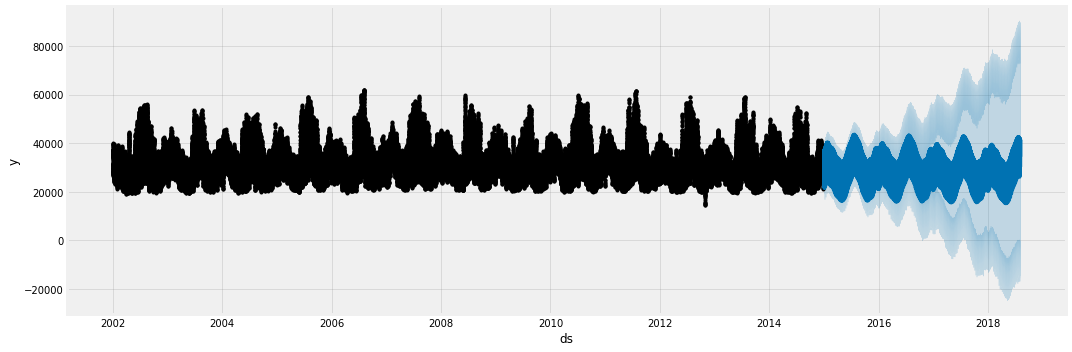

In [13]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()